# t-SNE clustering of gene expression for brain regions

In [1]:
import functools
import numpy as np
import pandas as pd
from plotnine import *
import seaborn as sns
from os import environ
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from warnings import filterwarnings
from sklearn.feature_selection import VarianceThreshold

In [2]:
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')
environ['NUMEXPR_MAX_THREADS'] = '16'

## Functions

In [3]:
@functools.lru_cache()
def get_pheno():
    fname = "/ceph/projects/v4_phase3_paper/inputs/phenotypes/_m/merged_phenotypes.csv"
    return pd.read_csv(fname, index_col=0)


@functools.lru_cache()
def filter_pheno():
    return get_pheno()[~((get_pheno()["Region"] == "HIPPO") & 
                         (get_pheno()["Protocol"] != "RiboZeroHMR"))]


def VarianceThreshold_selection(data, var):
    df1 = data.copy(deep=True)
    selector = VarianceThreshold(var).fit(df1)
    return df1.loc[:, selector.get_support(indices=False)]


def save_plots(p, fn, w, h):
    for ext in ['.png', '.pdf', '.svg']:
        p.save(filename=fn+ext, width=w, height=h)


## Phase 2 comparison

### Possible sample/region swap identification

In [4]:
## Load BrainSeq Phase 2 information
BSP2 = pd.read_csv("../_h/bsp2_info.csv.gz", index_col=0).loc[:, ["BrNum"]]
print(BSP2.shape)
## Merge with current phase 2 data
dfx = get_pheno().loc[:, ["BrNum"]].merge(BSP2, left_index=True, right_index=True)
np.sum(dfx.BrNum_x == dfx.BrNum_y)

(900, 1)


898

In [5]:
dfx[(dfx.BrNum_x != dfx.BrNum_y)] ## This is fixed already

,BrNum_x,BrNum_y
RNum,,
R4806,Br922,Br0922
R3921,Br922,Br0922


### Load data

In [6]:
caudate = pd.read_csv("/ceph/projects/v4_phase3_paper/inputs/counts/text_files_counts/tpm/_m/caudate/gene/log2tpm.csv", index_col=0)
dlpfc = pd.read_csv("/ceph/projects/v4_phase3_paper/inputs/counts/text_files_counts/tpm/_m/dlpfc/gene/log2tpm.csv", index_col=0)
hippo = pd.read_csv("/ceph/projects/v4_phase3_paper/inputs/counts/text_files_counts/tpm/_m/hippocampus/gene/log2tpm.csv", index_col=0)
df = pd.concat([caudate, dlpfc, hippo], axis=1, join='inner')
df["ensemblID"] = df.index.str.replace("\\..*", "", regex=True)
df = df.reset_index().set_index("ensemblID").drop("names", axis=1)
print(df.shape)
df.iloc[0:2, 0:5]

(47062, 1217)


,R12864,R12865,R12866,R12867,R12868
ensemblID,,,,,
ENSG00000223972,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000227232,3.338405,3.566059,3.825159,3.516031,3.833224


### Merge data

In [7]:
dft = VarianceThreshold_selection(df.T, 0.05)
bigdf = pd.merge(get_pheno(), dft, left_index=True, right_index=True)
bigdf.shape

(1217, 29102)

In [8]:
bigdf2 = pd.merge(filter_pheno(), dft, left_index=True, right_index=True)
bigdf2.shape

(1174, 29102)

In [9]:
dft2 = dft.loc[bigdf2.index]
dft2.shape

(1174, 29082)

### Plotting

#### Unfiltered data

/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


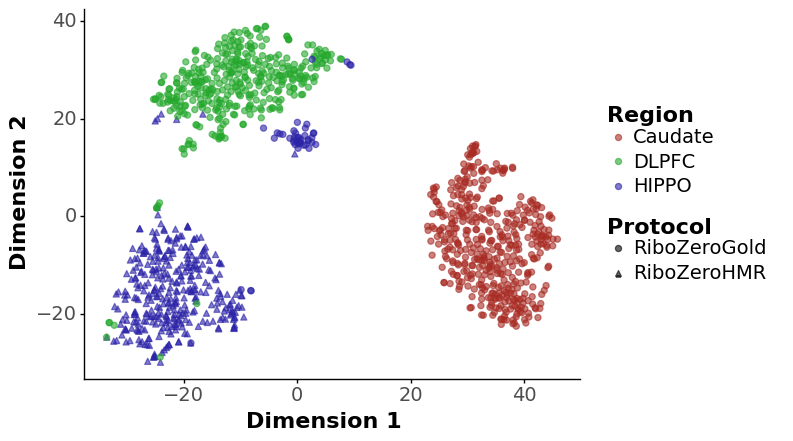

<ggplot: (8749099957230)>


In [10]:
embedded = TSNE(n_components=2, random_state=13).fit_transform(dft)
#embedded = UMAP(random_state=13).fit_transform(dft)

newdf = pd.DataFrame(embedded, index=dft.index)\
       .rename(columns={0:'Dimension1', 1:'Dimension2'})\
       .merge(get_pheno(), left_index=True, right_index=True)
newdf.to_csv("libd_brains_tsne.csv", index=True, header=True)

gg = ggplot(newdf, aes(x='Dimension1', y='Dimension2', color='Region', shape="Protocol")) + \
    geom_point(alpha=0.6, size=2) + labs(x="Dimension 1", y="Dimension 2") + \
    theme_classic() + scale_color_hue(l=0.4, c=35) + \
    theme(axis_text=element_text(size=14), 
          axis_title=element_text(size=16, face="bold"), 
          legend_text=element_text(size=14), 
          legend_title=element_text(size=16, face="bold")) 
print(gg)
save_plots(gg, 'log2tpm_genes_libd_brains_tsne', 7, 6)

#### Filtered data

/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


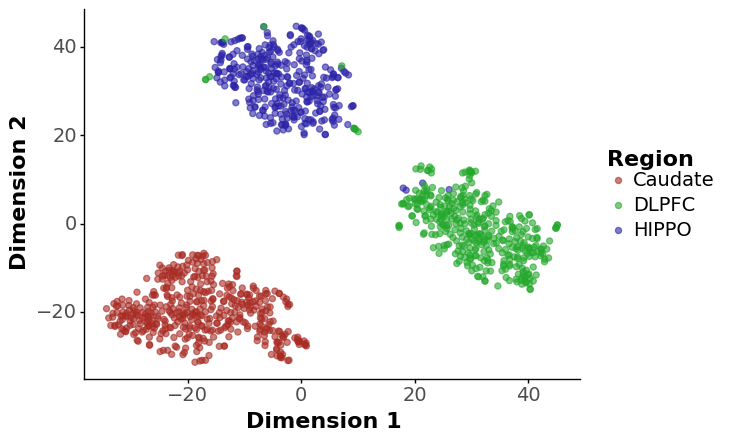

<ggplot: (8748326817823)>


In [35]:
embedded = TSNE(n_components=2, random_state=13).fit_transform(dft2)
#embedded = UMAP(random_state=13).fit_transform(dft)

newdf = pd.DataFrame(embedded, index=dft2.index)\
       .rename(columns={0:'Dimension1', 1:'Dimension2'})\
       .merge(filter_pheno(), left_index=True, right_index=True)
newdf.to_csv("libd_brains_tsne_filtered.csv", index=True, header=True)

gg = ggplot(newdf, aes(x='Dimension1', y='Dimension2', color='Region')) + \
    geom_point(alpha=0.6, size=2) + labs(x="Dimension 1", y="Dimension 2") + \
    theme_classic() + scale_color_hue(l=0.4, c=35) + \
    theme(axis_text=element_text(size=14), 
          axis_title=element_text(size=16, face="bold"), 
          legend_text=element_text(size=14), 
          legend_title=element_text(size=16, face="bold")) 
print(gg)
save_plots(gg, 'log2tpm_genes_libd_brains_tsne_filtered', 7, 6)

#### Threshold filtering

In [38]:
cc = newdf[(newdf["Region"] == "Caudate")].copy()
dd = newdf[(newdf["Region"] == "DLPFC") & (newdf["Dimension2"] < 20)].copy()
hh = newdf[(newdf["Region"] == "HIPPO") & (newdf["Dimension2"] > 15)].copy()
newdf2 = pd.concat([cc, dd, hh], axis=0)
newdf2.shape

(1160, 22)

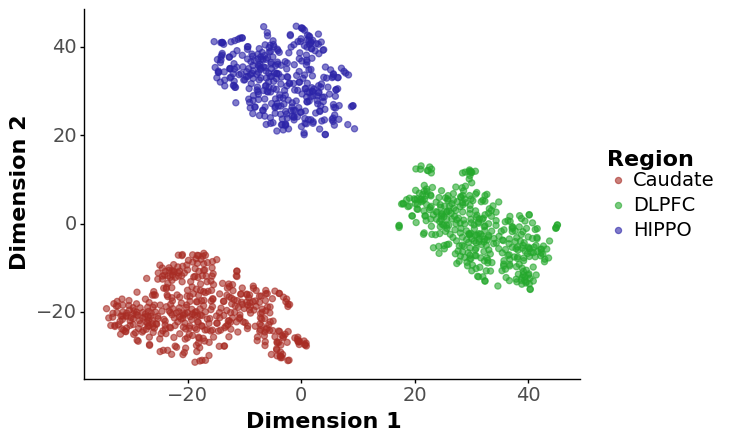

<ggplot: (8748326966251)>


In [40]:
gg = ggplot(newdf2, aes(x='Dimension1', y='Dimension2', color='Region')) + \
    geom_point(alpha=0.6, size=2) + labs(x="Dimension 1", y="Dimension 2") + \
    theme_classic() + scale_color_hue(l=0.4, c=35) + \
    theme(axis_text=element_text(size=14), 
          axis_title=element_text(size=16, face="bold"), 
          legend_text=element_text(size=14), 
          legend_title=element_text(size=16, face="bold")) 
print(gg)
save_plots(gg, 'log2tpm_genes_libd_brains_tsne_filtered_thresholding', 7, 6)

In [41]:
dx = newdf[(newdf["Region"] == "DLPFC") & (newdf["Dimension2"] > 20)].copy()
hx = newdf[(newdf["Region"] == "HIPPO") & (newdf["Dimension2"] < 15)].copy()
pd.concat([dx, hx], axis=0).to_csv("libd_brainseq_dropped_samples.csv", index=True, header=True)

## GTEx comparison

In [12]:
gtex0 = pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/"+\
                    "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz", 
                    sep='\t', skiprows=[0,1], low_memory=False, comment='#', 
                    nrows=100, index_col=0)
gtex = pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/"+\
                   "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz", 
                   sep='\t', skiprows=[0,1], low_memory=True, comment='#', index_col=0,
                   dtype=gtex0.dtypes.to_dict())
gtex.drop("Description", axis=1, inplace=True)
print(gtex.shape)
gtex.iloc[0:2, 0:5]

(56200, 17382)


,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN
Name,,,,,
ENSG00000223972.5,0.000,0.000,0.000,0.00,0.000
ENSG00000227232.5,8.764,3.861,7.349,11.07,3.306


In [13]:
gtex_pheno = pd.read_csv("/ceph/projects/v4_phase3_paper/inputs/public_data/_m/gtex_v8/gtex_v8_sample_data.txt", 
                         sep='\t', low_memory=False, index_col=4)
print(gtex_pheno.shape)
samples = list(set(gtex.columns) & set(gtex_pheno.index))
gtex_pheno = gtex_pheno.loc[samples, :]
print(gtex_pheno.shape)

(22951, 79)
(17382, 79)


In [14]:
gtex = gtex.loc[:, samples]
log2tpm_gtex = np.log(gtex + 1)

log2tpm_gtex["ensemblID"] = log2tpm_gtex.index.str.replace("\\..*", "", regex=True)
log2tpm_gtex = log2tpm_gtex.reset_index().set_index("ensemblID").drop("Name", axis=1)
print(log2tpm_gtex.shape)

dft_gtex = VarianceThreshold_selection(log2tpm_gtex.T, 0.05)
print(dft_gtex.shape)

(56200, 17382)
(17382, 30237)


/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


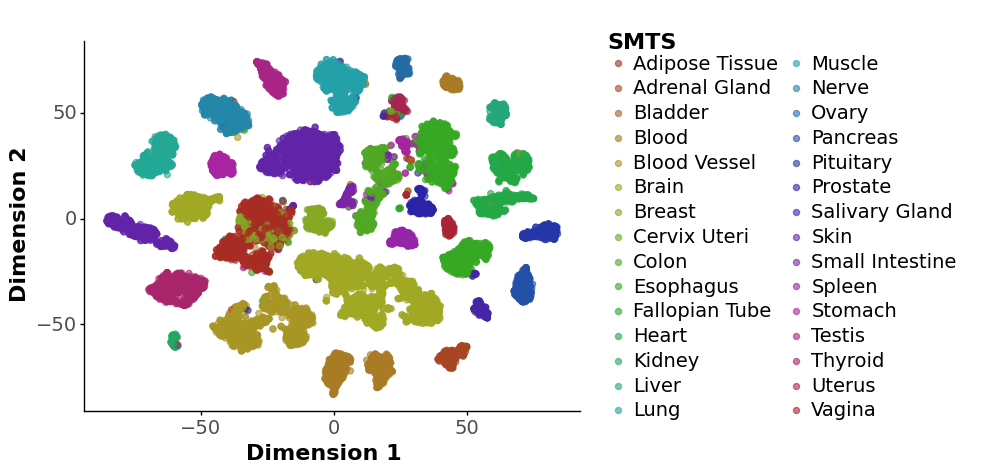

<ggplot: (8749097829816)>


In [15]:
embedded = TSNE(n_components=2, random_state=13).fit_transform(dft_gtex)
#embedded = UMAP(random_state=13).fit_transform(dft)

newdf = pd.DataFrame(embedded, index=dft_gtex.index)\
       .rename(columns={0:'Dimension1', 1:'Dimension2'})\
       .merge(gtex_pheno, left_index=True, right_index=True)
newdf.to_csv("gtex_all_tsne.csv", index=True, header=True)

gg = ggplot(newdf, aes(x='Dimension1', y='Dimension2', color='SMTS')) + \
    geom_point(alpha=0.6, size=2) + labs(x="Dimension 1", y="Dimension 2") + \
    theme_classic() + scale_color_hue(l=0.4, c=35) + \
    theme(axis_text=element_text(size=14), 
          axis_title=element_text(size=16, face="bold"), 
          legend_text=element_text(size=14), 
          legend_title=element_text(size=16, face="bold")) 
print(gg)
save_plots(gg, 'log2tpm_genes_gtex_all_tsne', 7, 6)

### GTEx Brain regions only

In [16]:
cvars = ["SMCENTER", "SMNABTCHT"]
gtex_brains = gtex_pheno[(gtex_pheno["SMTS"] == "Brain")].copy()
dft_gtex_brains = dft_gtex.loc[gtex_brains.index, :].copy()

/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


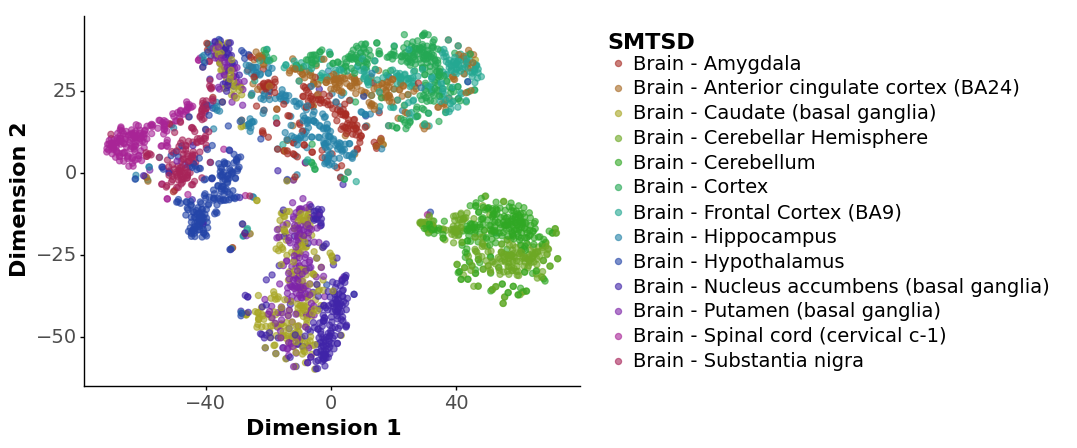

<ggplot: (8749097836575)>


In [17]:
embedded = TSNE(n_components=2, random_state=13).fit_transform(dft_gtex_brains)

newdf_gtex = pd.DataFrame(embedded, index=dft_gtex_brains.index)\
       .rename(columns={0:'Dimension1', 1:'Dimension2'})\
       .merge(gtex_brains, left_index=True, right_index=True)
newdf_gtex.to_csv("gtex_brain_tsne.csv", index=True, header=True)

rr = ggplot(newdf_gtex, aes(x='Dimension1', y='Dimension2', color='SMTSD')) + \
    geom_point(alpha=0.6, size=2) + labs(x="Dimension 1", y="Dimension 2") + \
    theme_classic() + scale_color_hue(l=0.4, c=35) + \
    theme(axis_text=element_text(size=14), 
          axis_title=element_text(size=16, face="bold"), 
          legend_text=element_text(size=14), 
          legend_title=element_text(size=16, face="bold")) 
print(rr)
save_plots(rr, 'log2tpm_genes_gtex_brain_tsne', 7, 6)

### Combine GTEx and LIBD Caudate

In [18]:
combined_df = pd.concat([dft.loc[:, (list(set(dft.columns) & set(dft_gtex.columns)))], 
                         dft_gtex.loc[:, (list(set(dft.columns) & set(dft_gtex.columns)))]], axis=0)
print(combined_df.shape)
dt = newdf2.loc[:, ["Region"]].reset_index()\
           .rename(columns={"index": "SAMPID", "Region": "SMTSD"})
dt["SMTS"] = "LIBD_Brain"

bs_n_gtex = pd.concat([dt, gtex_pheno.reset_index().loc[:, ["SAMPID", "SMTS", "SMTSD"]]], axis=0)
bs_n_gtex = bs_n_gtex[(bs_n_gtex["SAMPID"].isin(list(set(combined_df.index) & set(bs_n_gtex.SAMPID))))]
print(bs_n_gtex.shape)
bs_n_gtex.head(2)

(18599, 23264)
(18599, 3)


,SAMPID,SMTSD,SMTS
0,R11135,HIPPO,LIBD_Brain
1,R11137,HIPPO,LIBD_Brain


/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


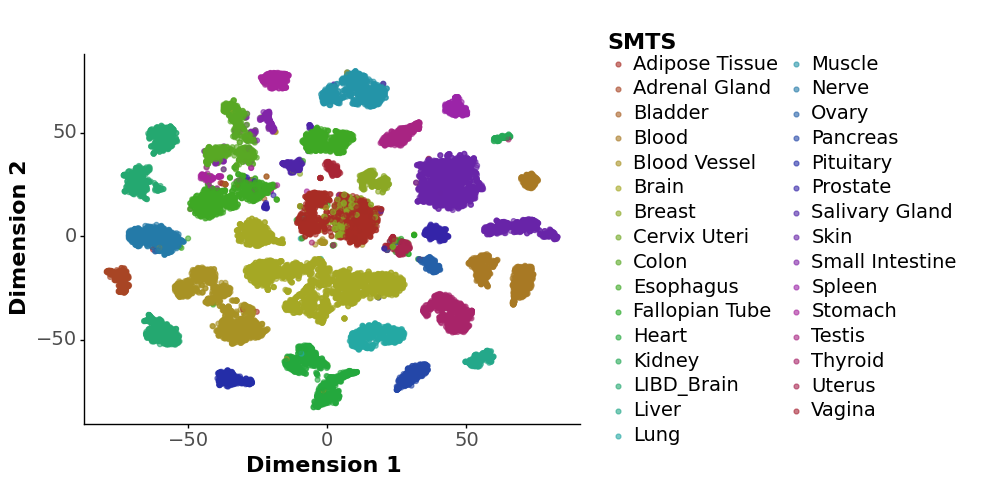

<ggplot: (8748857058801)>


In [19]:
embedded = TSNE(n_components=2, random_state=13).fit_transform(combined_df)
#embedded = UMAP(random_state=13).fit_transform(combined_df)

newdf = pd.DataFrame(embedded, index=combined_df.index)\
       .rename(columns={0:'Dimension1', 1:'Dimension2'})\
       .merge(bs_n_gtex, left_index=True, right_on="SAMPID")
newdf.to_csv("gtex_libd_tsne.csv", index=True, header=True)

ww = ggplot(newdf, aes(x='Dimension1', y='Dimension2', color='SMTS')) + \
    geom_point(alpha=0.6) + labs(x="Dimension 1", y="Dimension 2") + \
    theme_classic() + scale_color_hue(l=0.4, c=35) + \
    theme(axis_text=element_text(size=14), 
          axis_title=element_text(size=16, face="bold"), 
          legend_text=element_text(size=14), 
          legend_title=element_text(size=16, face="bold"))
print(ww)
save_plots(ww, 'log2tpm_genes_gtex_libd_tsne', 7, 6)

### Brain regions only

/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
/usr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.


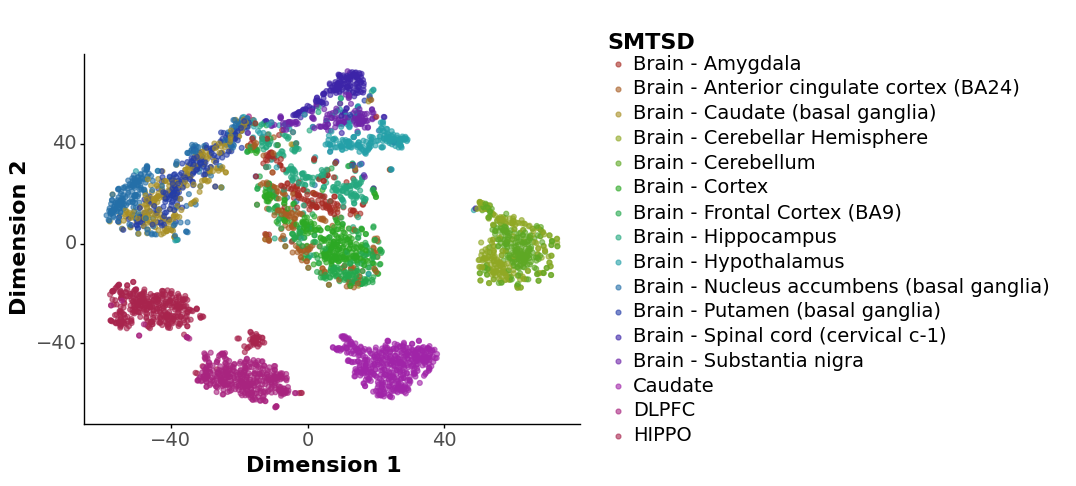

<ggplot: (8749100756767)>


In [20]:
bs_n_gtex_brains = bs_n_gtex[(bs_n_gtex["SMTS"].isin(["Brain", "LIBD_Brain"]))]
combined_df_brains = combined_df.loc[bs_n_gtex_brains.SAMPID, :].copy()

embedded = TSNE(n_components=2, random_state=13).fit_transform(combined_df_brains)
#embedded = UMAP(random_state=13).fit_transform(combined_df_brains)

dfz = pd.DataFrame(embedded, index=combined_df_brains.index)\
       .rename(columns={0:'Dimension1', 1:'Dimension2'})\
       .merge(bs_n_gtex, left_index=True, right_on="SAMPID")
dfz.to_csv("gtex_libd_brain_tsne.csv", index=True, header=True)

ww = ggplot(dfz, aes(x='Dimension1', y='Dimension2', color='SMTSD')) + \
    geom_point(alpha=0.6) + labs(x="Dimension 1", y="Dimension 2") + \
    theme_classic() + scale_color_hue(l=0.4, c=35) + \
    theme(axis_text=element_text(size=14), 
          axis_title=element_text(size=16, face="bold"), 
          legend_text=element_text(size=14), 
          legend_title=element_text(size=16, face="bold"))
print(ww)
save_plots(ww, 'log2tpm_genes_gtex_libd_brain_tsne', 7, 6)

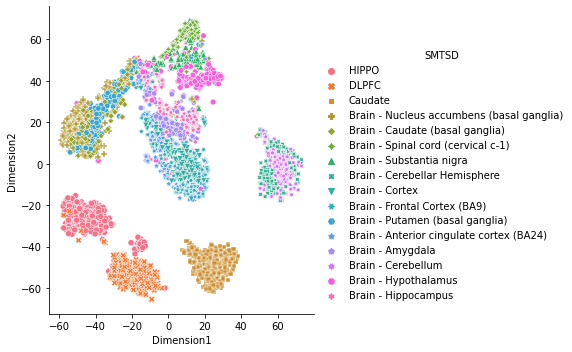

In [21]:
sns.relplot(data=dfz,x="Dimension1", y="Dimension2", hue="SMTSD", style="SMTSD")